In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
import scipy as sc
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

In [3]:
usr,passpath,datapath,prodatapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [49]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wdice.pkl"))

In [53]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])
mdl_preds_sorted.head()
mdl_preds_sorted.columns

Index(['Patient', 'iEEG_ID', 'model', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs',
       'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any',
       'ueo_consensus_chs', 'ueo_consensus_strict_dice',
       'ueo_consensus_loose_dice', 'ueo_any_chs', 'ueo_any_strict_dice',
       'ueo_any_loose_dice', 'sec_consensus_chs', 'sec_consensus_strict_dice',
       'sec_consensus_loose_dice', 'sec_any_chs', 'sec_any_strict_dice',
       'sec_any_loose_dice'],
      dtype='object')

In [54]:
melt_cols = [f'ueo_{anntype}_strict_dice',f'sec_{anntype}_{mdl_anntype}_dice']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.head()

,Patient,iEEG_ID,model,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,...,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice,annot,dice
0,HUP224,HUP224_phaseII,AbsSlp,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.109091,0.099585,"[LB01, LB02, LB03, LC01, LC02]",0.042735,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.100457,0.091667,ueo_consensus_strict_dice,0.100457
1,HUP224,HUP224_phaseII,LSTM,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA05, LA07, LA11, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA03, LA05, LA07, LA11, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.379310,0.275862,"[LB01, LB02, LB03, LC01, LC02]",0.136986,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.352941,0.278481,ueo_consensus_strict_dice,0.350877
2,HUP224,HUP224_phaseII,AbsSlp,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.109589,0.100000,"[LB01, LB02, LB03, LC01, LC02]",0.042918,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.101382,0.092050,ueo_consensus_strict_dice,0.100917
3,HUP224,HUP224_phaseII,LSTM,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA05, LA07, LA11, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA03, LA05, LA07, LA11, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.379310,0.275862,"[LB01, LB02, LB03, LC01, LC02]",0.136986,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.352941,0.278481,ueo_consensus_strict_dice,0.350877
4,HUP224,HUP224_phaseII,AbsSlp,71156.59,71156.59,0.10,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.110599,0.100418,"[LB01, LB02, LB03, LC01, LC02]",0.043103,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.103286,0.092437,ueo_consensus_strict_dice,0.101852


Text(0.5, 0.98, 'Model Annotator Agreement - consensus')

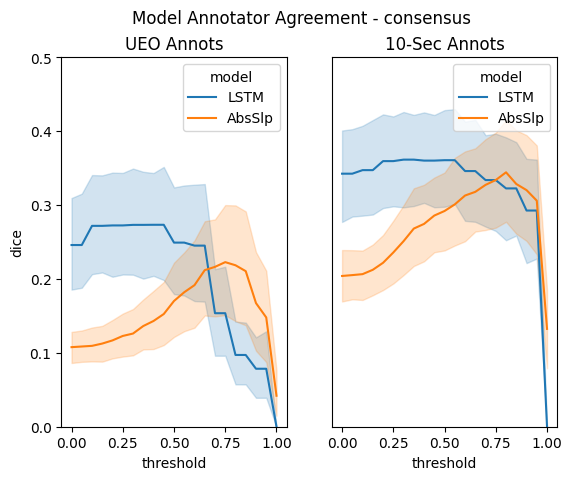

In [52]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[0])
axs[0].set_ylim((0,.5))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[1])
axs[1].set_ylim((0,.5))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')